In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'src')))
from classical.MeanVarianceOpt import MeanVarianceOpt

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# 🟢 Step 1: Loading the data

In [2]:
assets_path = r'../../data/100 close prices 5Y.csv'
close_prices = pd.read_csv(assets_path).set_index('date').dropna()

In [3]:
close_prices.columns

Index(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'UNH',
       'V', 'JNJ', 'HD', 'PG', 'MA', 'PEP', 'BAC', 'XOM', 'KO', 'LLY', 'AVGO',
       'MRK', 'WMT', 'ABBV', 'COST', 'TMO', 'DIS', 'ADBE', 'CSCO', 'CRM',
       'NFLX', 'INTC', 'ABT', 'CMCSA', 'MCD', 'DHR', 'TXN', 'AMD', 'NKE',
       'PFE', 'UPS', 'QCOM', 'PM', 'AMGN', 'BA', 'LOW', 'CAT', 'MS', 'BKNG',
       'GE', 'CVX', 'SPGI', 'USB', 'BLK', 'ISRG', 'CI', 'ZTS', 'AXP', 'TGT',
       'GILD', 'DE', 'FDX', 'MDLZ', 'GM', 'ORCL', 'ADP', 'SCHW', 'MO', 'VRTX',
       'SO', 'C', 'CL', 'AON', 'PLD', 'ETN', 'CB', 'WM', 'APD', 'D', 'TFC',
       'ECL', 'ADI', 'LRCX', 'F', 'BSX', 'PSX', 'HCA', 'MAR', 'EMR', 'CTSH',
       'ITW', 'TRV', 'MNST', 'AEP', 'KMB', 'MTD', 'HAL', 'ROK', 'KMI', 'HIG',
       'AIG'],
      dtype='object')

## Calaulating Returns and log-returns

In [4]:
returns = (close_prices / close_prices.shift()).dropna()
logs = np.log(close_prices / close_prices.shift()).dropna()

**To ensure visual clarity, I will use the 30 stocks that have yielded the highest returns from the initial point. This selection is arbitrary and does not carry any theoretical or mathematical justification.**

In [5]:
def make_wealth(df):
    start = df.iloc[0].values
    result = df / start

    return result

wealth_data = make_wealth(close_prices)

In [6]:
selected_tickers = wealth_data.iloc[-1].nlargest(30).index.values
selected_tickers

array(['AVGO', 'NVDA', 'GE', 'TSLA', 'LLY', 'ETN', 'HIG', 'DE', 'MS',
       'HCA', 'AXP', 'COST', 'CAT', 'BKNG', 'JPM', 'AIG', 'LRCX', 'ORCL',
       'TRV', 'PM', 'ISRG', 'CB', 'MAR', 'XOM', 'BSX', 'META', 'SCHW',
       'WMT', 'AAPL', 'ADP'], dtype=object)

In [7]:
df = logs.loc[:, selected_tickers]

# 🟢 Step 2: Call ```MeanVarianceOpt```
The ```MeanVarOpt``` requires only one parameter for its initialization: your pandas dataframe.  
📌 Note: this dataframe **must** contain your log-returns. Any other kind of data will result miscalculations. 

In [8]:
optimizer = MeanVarianceOpt(df)

INFO:root:DataFrame index type: Index was automatically converted into pd.DatetimeIndex.


## Main Properties (these attributes can be used before and after optimizing the weights)

### ```correlation_matrix```
Will output the correlation matrix of the stocks.

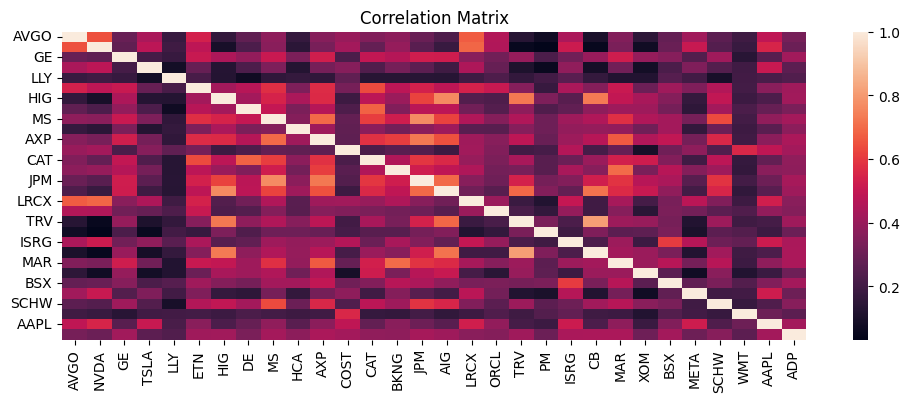

In [9]:
corrmat = optimizer.correlation_matrix
plt.figure(figsize=(12,4))
sns.heatmap(corrmat)
plt.title('Correlation Matrix')
plt.show()

### ```covariance_matrix```
will output the covariance matrix of the stocks. 

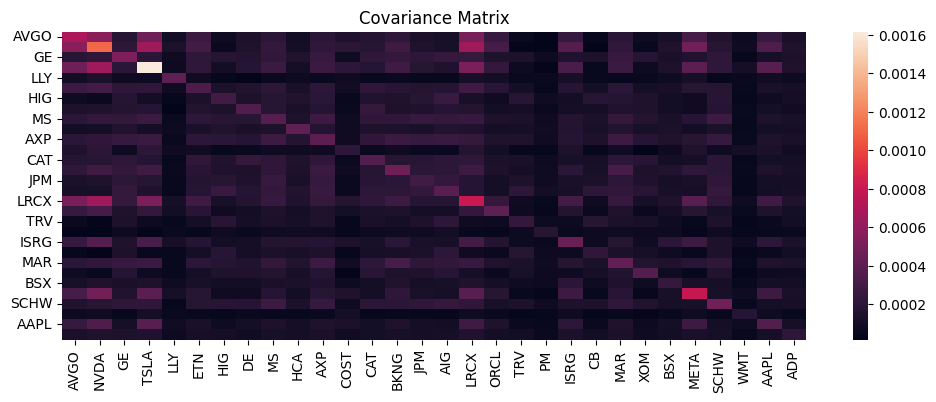

In [10]:
covmat = optimizer.covariance_matrix
plt.figure(figsize=(12,4))
sns.heatmap(covmat)
plt.plot('Covariance Matrix')
plt.title('Covariance Matrix')
plt.show()

### ```volatilities```
Will output the valitilities of the stocks, normalized to daily terms.

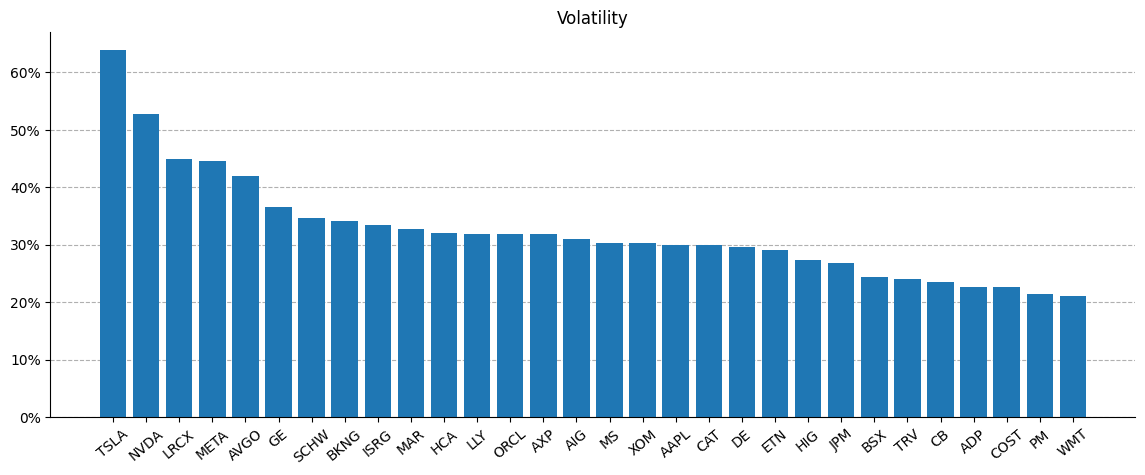

In [11]:
vols = optimizer.volatilities.sort_values(ascending=False)
plt.figure(figsize=(14,5))
plt.bar(vols.index, vols.values, zorder=2)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xticks(rotation=40)
plt.title('Volatility')
plt.grid(axis='y', ls='--', zorder=0)
sns.despine()
plt.show()

# 🔍 Step 3: Optimizing the Weights

To optimize your portfolio, simply call the `optimize_weights` method.  
This method lets you control how the optimization behaves using four key parameters:

1. `target_return`:  
   The return you’d like your portfolio to achieve. The method will adjust the weights to aim for this target.

2. `min_weight`:  
   The lowest possible weight any asset can get. You can set it to a negative number (to allow shorting) — but only if `short_allowed` is set to `True`.  
   Just make sure it's not higher than `max_weight`.

3. `max_weight`:  
   The highest weight any asset can receive. Like `min_weight`, it can be negative if shorting is allowed, but must be at least as large as `min_weight`.

4. `short_allowed`:  
   Set this to `True` if you want to allow short positions (i.e., negative weights).  
   By default, it’s set to `False`, meaning only long positions are allowed.

In [12]:
optimizer.optimize_weights(target_return=0.18, short_allowed=True, min_weight=-0.15, max_weight=0.2)

INFO:root:Optimization completed successfully. Problem status: optimal


## After-Optimization Properties

### ```best_wightes```
As expected, once the weights have been optimized, the resulting weights can be retrieved immediately.
The ```best_weights``` property returns a Pandas Series containing these values, according to the specifications of the optimization.

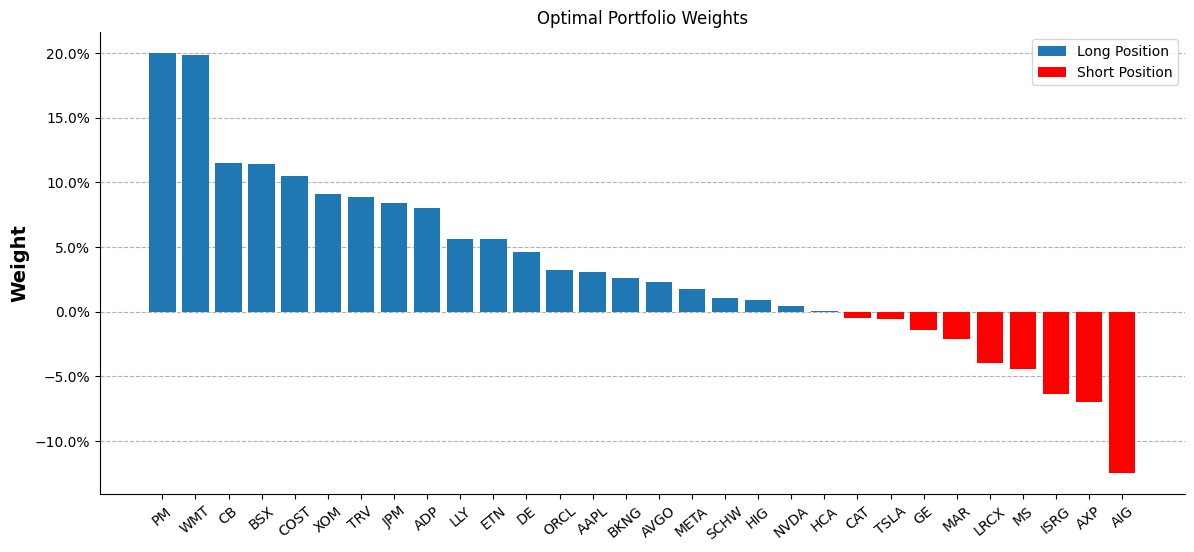

In [13]:
best_weihgts = optimizer.best_weights.sort_values(ascending=False)
longs = best_weihgts[best_weihgts>=0]
shorts = best_weihgts[best_weihgts<0]

plt.figure(figsize=(14, 6))
plt.bar(longs.index, longs.values, zorder=2, label='Long Position')
plt.bar(shorts.index, shorts.values, color='r', zorder=2, label='Short Position')

plt.ylabel('Weight', weight='bold', size=14)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.title('Optimal Portfolio Weights')
plt.xticks(rotation=40)
plt.grid(ls='--', axis='y', zorder=0)
plt.legend()
sns.despine()
plt.show()

### ```summary```
The `summary` property provides a quick overview of the optimization results.  
It returns the following:

1. The portfolio variance  
2. The portfolio standard deviation  
3. The expected portfolio return

📌 **Note**: The outputs are expressed in terms of arithmetic returns, not log returns.

In [14]:
optimizer.summary

--------------------------------------------------
Portfolio Summary
--------------------------------------------------
Portfolio Variance: 0.000076
Portfolio Standard Deviation: 0.008702
Expected Annual Return: 27.32%


**If you're interested in retrieving one of these values individually, you can access them through their respective properties.  
Note that to obtain the portfolio standard deviation, you'll need to calculate it manually - simply by taking the square root of the variance.**

In [15]:
expected_return = optimizer.portfolio_expected_return
expected_var = optimizer.portfolio_variance
expected_std = np.sqrt(expected_var)
print(f'Porftolio Expected Annualized Return: {expected_return:.5f}')
print(f'Portfolio Expected Variance: {expected_var:.5f}')
print(f'Portfolio Expected Std: {expected_std:.5f}')

Porftolio Expected Annualized Return: 1.27323
Portfolio Expected Variance: 0.00008
Portfolio Expected Std: 0.00870


### ```portfolio_wealth```
This method allows you to evaluate the historical performance of the portfolio obtained from the optimization solution.  
By using a simple function like ```make_wealth```, you can compare the portfolio's performance against its underlying assets or any other benchmarks.  

📌 **Note**: The outputs are expressed in terms of arithmetic returns, not log returns.

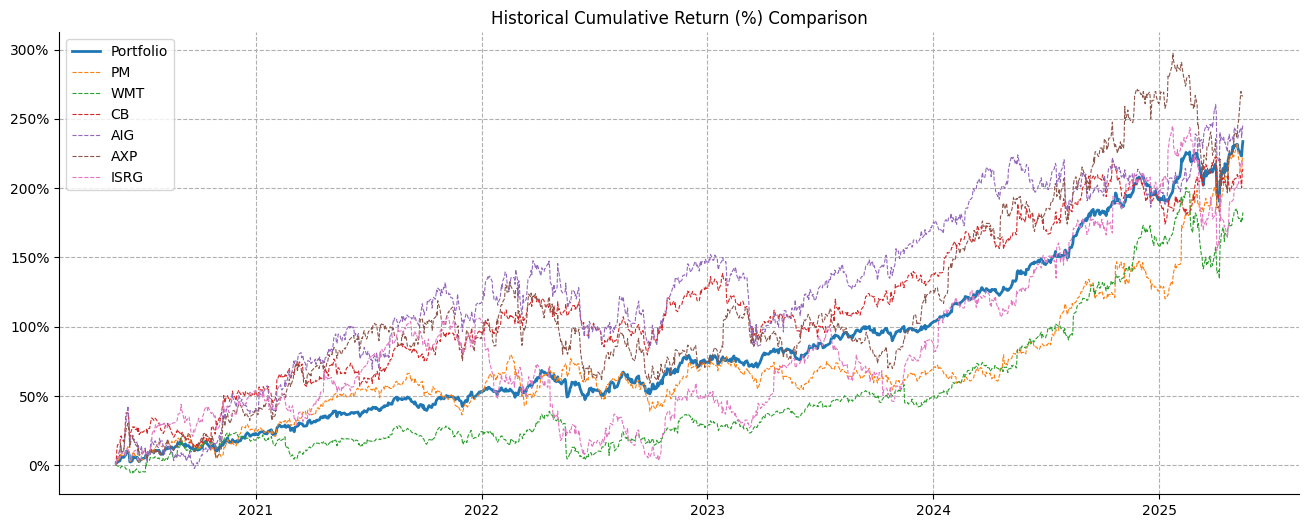

In [16]:
port_historical_performance = optimizer.portfolio_wealth - 1
wealth_data.index = pd.to_datetime(wealth_data.index)
tickers = ['PM', 'WMT', 'CB', 'AIG', 'AXP', 'ISRG']

plt.figure(figsize=(16,6))

plt.plot(port_historical_performance, label='Portfolio', lw=2)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

for t in tickers:
    plt.plot(wealth_data[t]-1, label=t, ls='--', lw=.8)

plt.title('Historical Cumulative Return (%) Comparison')
plt.grid(ls='--')
plt.legend()
sns.despine()
plt.show()

### ```portfolio_log_history```
This method allows you to retrieve information about the historical log-returns of the portfolio.  
Such information enables analysis of the portfolio's performance distribution over the optimization period.  
In profiles where the optimization was successful, we would typically expect to observe some degree of skewness toward positive returns.

A similiar method, ```portfolio_history```, is available to provide the relative returns history.

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


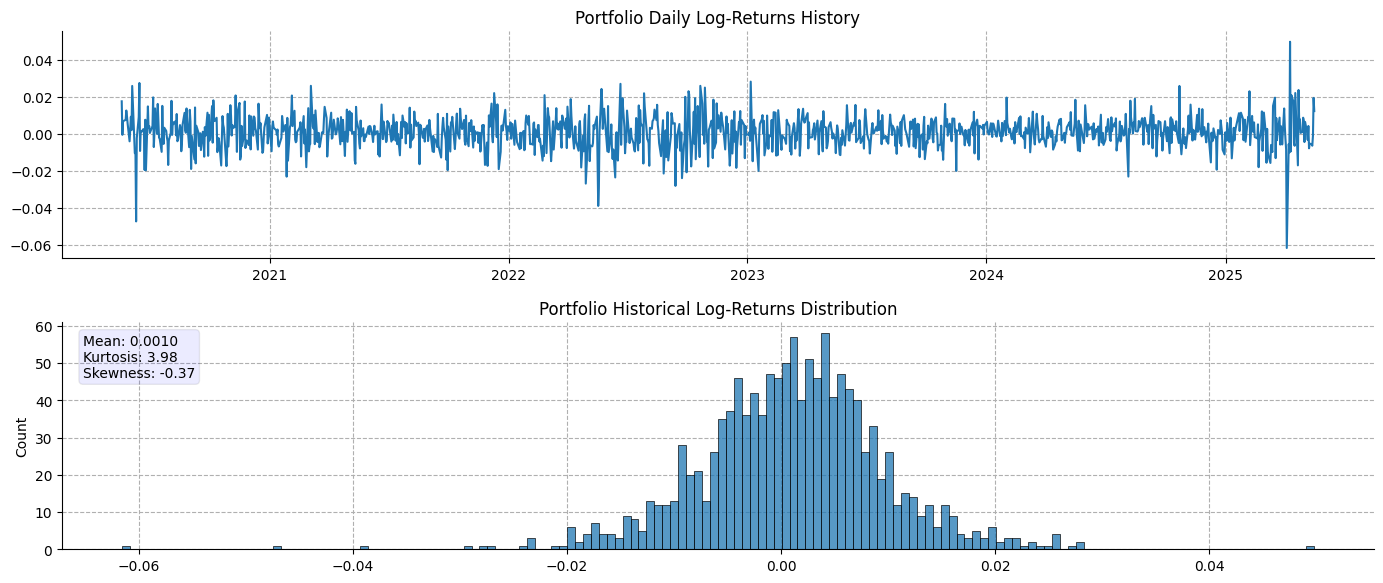

In [17]:
hist = optimizer.portfolio_log_history
fig, ax = plt.subplots(2,1, figsize=(14,6))
ax[0].plot(hist)
ax[0].set_title('Portfolio Daily Log-Returns History')
ax[0].grid(ls='--')


mean = np.mean(hist)
kurto = kurtosis(hist)
skweness = skew(hist)
sns.histplot(hist, ax=ax[1], bins=150, zorder=2)
ax[1].grid(ls='--', zorder=0)
ax[1].set_title('Portfolio Historical Log-Returns Distribution')
textstr = f"Mean: {mean:.4f}\nKurtosis: {kurto:.2f}\nSkewness: {skweness:.2f}"
props = dict(boxstyle='round', facecolor='blue', alpha=0.08)
ax[1].text(0.016, 0.95, textstr, transform=ax[1].transAxes,
           fontsize=10, verticalalignment='top', horizontalalignment='left',
           bbox=props)

plt.tight_layout(pad=1.3)
sns.despine()
plt.show()